Error parsing GPU log at line 76251: list index out of range
Error parsing GPU log at line 79795: list index out of range
               Start_Time                End_Time  GPU_Utilization  \
0 1900-01-01 14:00:45.080 1900-01-01 14:00:46.210                0   
1 1900-01-01 14:00:46.210 1900-01-01 14:00:47.160                0   
2 1900-01-01 14:00:47.160 1900-01-01 14:00:48.190                0   
3 1900-01-01 14:00:48.190 1900-01-01 14:00:48.770                0   
4 1900-01-01 14:00:48.780 1900-01-01 14:00:49.150                0   

   Cumulative_Start_Seconds  Cumulative_End_Seconds  
0                      0.01                    1.14  
1                      1.14                    2.09  
2                      2.09                    3.12  
3                      3.12                    3.70  
4                      3.71                    4.08  
  Classifier    Feature_Extractor              Start_Time  \
0   logistic         tfidfsigmoid 1900-01-01 14:00:45.070   
1   logisti

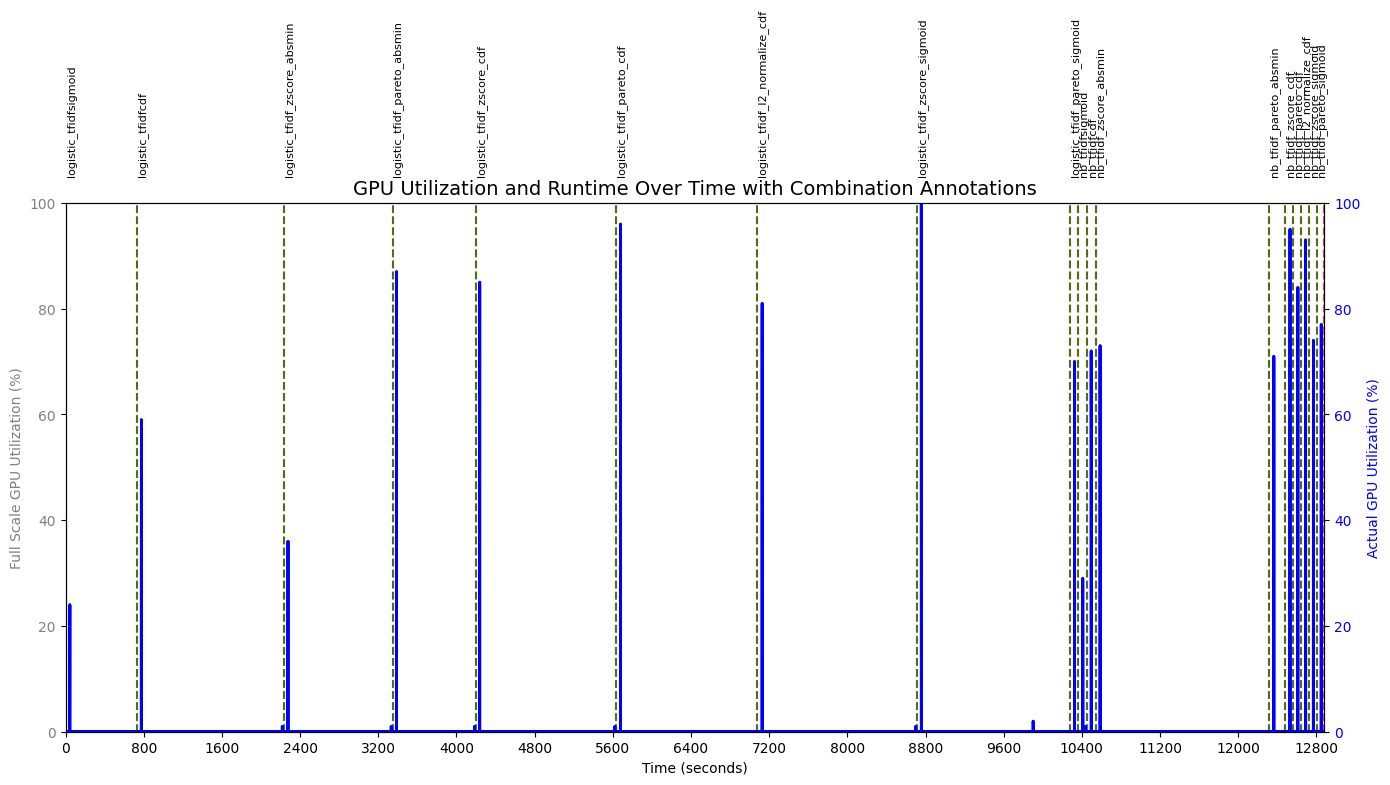


First few rows of GPU DataFrame:
               Start_Time                End_Time  GPU_Utilization  \
0 1900-01-01 14:00:45.080 1900-01-01 14:00:46.210                0   
1 1900-01-01 14:00:46.210 1900-01-01 14:00:47.160                0   
2 1900-01-01 14:00:47.160 1900-01-01 14:00:48.190                0   
3 1900-01-01 14:00:48.190 1900-01-01 14:00:48.770                0   
4 1900-01-01 14:00:48.780 1900-01-01 14:00:49.150                0   

   Cumulative_Start_Seconds  Cumulative_End_Seconds  
0                      0.01                    1.14  
1                      1.14                    2.09  
2                      2.09                    3.12  
3                      3.12                    3.70  
4                      3.71                    4.08  

First few rows of Combination DataFrame:
  Classifier    Feature_Extractor              Start_Time  \
0   logistic         tfidfsigmoid 1900-01-01 14:00:45.070   
1   logistic             tfidfcdf 1900-01-01 14:12:57.040

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log files
gpu_log_path = 'system_metrics.log'
results_log_path = 'results.log'

# Read the log files
with open(gpu_log_path, 'r') as file:
    gpu_log_content = file.read()

with open(results_log_path, 'r') as file:
    results_log_content = file.read()

# Function to parse GPU utilization log
def parse_gpu_log(gpu_log_content):
    gpu_data = []
    lines = gpu_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            line = lines[i].strip()
            if line.startswith('Time start:'):
                start_time = pd.to_datetime(line.split('Time start:')[1].strip(), format='%H:%M:%S,%f')
            elif line.startswith('utilization.gpu [%]'):
                gpu_util = int(lines[i + 1].strip().replace('%', ''))
                end_time = pd.to_datetime(lines[i + 2].strip().split('Time end:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                gpu_data.append((start_time, end_time, gpu_util))
                i += 2  # Skip 'Time end' line
            i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing GPU log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(gpu_data, columns=['Start_Time', 'End_Time', 'GPU_Utilization'])

# Function to parse combinations log
def parse_combination_log(combination_log_content):
    comb_data = []
    lines = combination_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            if lines[i].startswith('Running classifier:'):
                classifier = lines[i].split('classifier:')[1].split('with')[0].strip()
                feature_extractor = lines[i].split('feature extractor:')[1].strip()
                start_time = pd.to_datetime(lines[i + 1].split('Start Time:')[1].strip(), format='%H:%M:%S,%f')
                end_time = pd.to_datetime(lines[i + 4].split('End Time:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                runtime = (end_time - start_time).total_seconds()
                comb_data.append((classifier, feature_extractor, start_time, end_time, runtime))
                i += 6
            else:
                i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing combination log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(comb_data, columns=['Classifier', 'Feature_Extractor', 'Start_Time', 'End_Time', 'Runtime_Seconds'])

# Parse the logs
gpu_df = parse_gpu_log(gpu_log_content)
comb_df = parse_combination_log(results_log_content)

# Filter out irrelevant or erroneous data points (e.g., extremely high values)
gpu_df = gpu_df[gpu_df['GPU_Utilization'] <= 100]

# Convert datetime columns to timestamps
gpu_df['Start_Time'] = pd.to_datetime(gpu_df['Start_Time'])
gpu_df['End_Time'] = pd.to_datetime(gpu_df['End_Time'])
comb_df['Start_Time'] = pd.to_datetime(comb_df['Start_Time'])
comb_df['End_Time'] = pd.to_datetime(comb_df['End_Time'])

# Calculate the runtime for each combination
comb_df['Runtime_Seconds'] = (comb_df['End_Time'] - comb_df['Start_Time']).dt.total_seconds()

# Calculate the cumulative runtime for each combination
comb_df['Cumulative_Start_Seconds'] = comb_df['Runtime_Seconds'].cumsum() - comb_df['Runtime_Seconds']
comb_df['Cumulative_End_Seconds'] = comb_df['Runtime_Seconds'].cumsum()

# Initialize columns for GPU utilization cumulative seconds
gpu_df['Cumulative_Start_Seconds'] = 0.0
gpu_df['Cumulative_End_Seconds'] = 0.0

# Calculate GPU utilization seconds based on cumulative runtime
for i, row in comb_df.iterrows():
    mask = (gpu_df['Start_Time'] >= row['Start_Time']) & (gpu_df['End_Time'] <= row['End_Time'])
    gpu_df.loc[mask, 'Cumulative_Start_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df.loc[mask, 'Start_Time'] - row['Start_Time']).dt.total_seconds()
    gpu_df.loc[mask, 'Cumulative_End_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df.loc[mask, 'End_Time'] - row['Start_Time']).dt.total_seconds()

# Display updated DataFrame for verification
print(gpu_df.head())
print(comb_df.head())

# Check for any empty columns
print("Empty columns in gpu_df:")
print(gpu_df.isnull().sum())
print("Empty columns in comb_df:")
print(comb_df.isnull().sum())

print("GPU DataFrame:")
print(gpu_df.describe())
print("\nCombination DataFrame:")
print(comb_df.describe())

# Modify the plotting section:
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot GPU utilization over time as a continuous line
gpu_times = []
gpu_utils = []
for _, row in gpu_df.iterrows():
    gpu_times.extend([row['Cumulative_Start_Seconds'], row['Cumulative_End_Seconds']])
    gpu_utils.extend([row['GPU_Utilization'], row['GPU_Utilization']])

print(f"GPU Times range: {min(gpu_times)} to {max(gpu_times)}")
print(f"GPU Utilizations range: {min(gpu_utils)} to {max(gpu_utils)}")

if len(gpu_times) > 0 and len(gpu_utils) > 0:
    ax1.plot(gpu_times, gpu_utils, color='b', linewidth=2)  # Increased line width
    
    # Create a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(gpu_times, gpu_utils, color='b', linewidth=2)
    
    # Set y-axis limits based on actual data range for ax2
    utilization_min = max(0, min(gpu_utils) - 5)  # Add some padding below
    utilization_max = min(100, max(gpu_utils) + 5)  # Add some padding above
    ax2.set_ylim(utilization_min, utilization_max)
    ax2.set_ylabel('Actual GPU Utilization (%)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
else:
    print("Warning: No GPU utilization data to plot")

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Full Scale GPU Utilization (%)', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.set_ylim(0, 100)  # Keep the full 0-100% scale on the left axis

# Annotate the plot with combinations and runtime
for _, row in comb_df.iterrows():
    ax1.axvline(x=row['Cumulative_Start_Seconds'], color='g', linestyle='--', alpha=0.7)
    ax1.axvline(x=row['Cumulative_End_Seconds'], color='r', linestyle='--', alpha=0.7)
    ax1.text(row['Cumulative_Start_Seconds'], 105, 
             f"{row['Classifier']}_{row['Feature_Extractor']}", 
             rotation=90, verticalalignment='bottom', fontsize=8)

# Set x-axis limits to cover the entire runtime
total_runtime = comb_df['Runtime_Seconds'].sum()
ax1.set_xlim(0, max(total_runtime, 1))  # Ensure the x-axis is at least 1 second wide

# Adding more ticks to the x-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))  # Adjust the number as needed
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.xticks(rotation=45)

# Add title and adjust layout
plt.title('GPU Utilization and Runtime Over Time with Combination Annotations', fontsize=14)
fig.tight_layout()

# Save the plot to a file
fig.savefig("output_graph.png", bbox_inches='tight')

# Display the plot
plt.show()

# Additional debugging: print the first few rows of each DataFrame
print("\nFirst few rows of GPU DataFrame:")
print(gpu_df.head())
print("\nFirst few rows of Combination DataFrame:")
print(comb_df.head())


In [15]:
import pandas as pd
import numpy as np

# Function to parse GPU utilization log
def parse_gpu_log(gpu_log_content):
    gpu_data = []
    lines = gpu_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            line = lines[i].strip()
            if line.startswith('Time start:'):
                start_time = pd.to_datetime(line.split('Time start:')[1].strip(), format='%H:%M:%S,%f')
            elif line.startswith('utilization.gpu [%]'):
                gpu_util = int(lines[i + 1].strip().replace('%', ''))
                end_time = pd.to_datetime(lines[i + 2].strip().split('Time end:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                gpu_data.append((start_time, end_time, gpu_util))
                i += 2  # Skip 'Time end' line
            i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing GPU log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(gpu_data, columns=['Start_Time', 'End_Time', 'GPU_Utilization'])

# Function to parse combinations log
def parse_combination_log(combination_log_content):
    comb_data = []
    lines = combination_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            if lines[i].startswith('Running classifier:'):
                classifier = lines[i].split('classifier:')[1].split('with')[0].strip()
                feature_extractor = lines[i].split('feature extractor:')[1].strip()
                start_time = pd.to_datetime(lines[i + 1].split('Start Time:')[1].strip(), format='%H:%M:%S,%f')
                end_time = pd.to_datetime(lines[i + 4].split('End Time:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                runtime = (end_time - start_time).total_seconds()
                comb_data.append((classifier, feature_extractor, start_time, end_time, runtime))
                i += 6
            else:
                i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing combination log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(comb_data, columns=['Classifier', 'Feature_Extractor', 'Start_Time', 'End_Time', 'Runtime_Seconds'])

# Parse the logs
gpu_df = parse_gpu_log(gpu_log_content)
comb_df = parse_combination_log(results_log_content)

# Filter out irrelevant or erroneous data points (e.g., extremely high values)
gpu_df = gpu_df[gpu_df['GPU_Utilization'] <= 100]

# Calculate the cumulative runtime for each combination
comb_df['Cumulative_Start_Seconds'] = comb_df['Runtime_Seconds'].cumsum() - comb_df['Runtime_Seconds']
comb_df['Cumulative_End_Seconds'] = comb_df['Runtime_Seconds'].cumsum()

# Calculate GPU utilization seconds based on cumulative runtime
gpu_df['Cumulative_Start_Seconds'] = 0
gpu_df['Cumulative_End_Seconds'] = 0

current_time = 0
for i, row in comb_df.iterrows():
    mask = (gpu_df['Start_Time'] >= row['Start_Time']) & (gpu_df['End_Time'] <= row['End_Time'])
    gpu_df.loc[mask, 'Cumulative_Start_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df['Start_Time'][mask] - row['Start_Time']).dt.total_seconds()
    gpu_df.loc[mask, 'Cumulative_End_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df['End_Time'][mask] - row['Start_Time']).dt.total_seconds()
    current_time = row['Cumulative_End_Seconds']

# Combine the information into a single table
combined_data = []

for i, row in comb_df.iterrows():
    mask = (gpu_df['Cumulative_Start_Seconds'] >= row['Cumulative_Start_Seconds']) & (gpu_df['Cumulative_End_Seconds'] <= row['Cumulative_End_Seconds'])
    gpu_utilizations = gpu_df.loc[mask, 'GPU_Utilization'].values
    avg_gpu_util = np.mean(gpu_utilizations) if len(gpu_utilizations) > 0 else 0
    combined_data.append({
        'Combination': f"{row['Classifier']} + {row['Feature_Extractor']}",
        'Runtime (seconds)': row['Runtime_Seconds'],
        'Average GPU Utilization (%)': int(avg_gpu_util)  # Format utilization as integer
    })

combined_df = pd.DataFrame(combined_data)

# Save the table as a CSV file
combined_df.to_csv('combined_gpu_utilization.csv', index=False)

Error parsing GPU log at line 49227: list index out of range


C:\Users\Sjard\AppData\Local\Temp\ipykernel_1107152\3675887256.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.0000e-02 6.2000e-01 1.6300e+00 2.6300e+00 3.5400e+00 4.5500e+00
 5.5500e+00 6.5600e+00 7.5800e+00 8.5800e+00 9.5900e+00 1.0600e+01
 1.1600e+01 1.2610e+01 1.3620e+01 1.4630e+01 1.5630e+01 1.6540e+01
 1.7550e+01 1.8560e+01 1.9570e+01 2.0580e+01 2.1580e+01 2.2580e+01
 2.3590e+01 2.4600e+01 2.5620e+01 2.6620e+01 2.7630e+01 2.8640e+01
 2.9550e+01 3.0550e+01 3.1570e+01 3.2580e+01 3.3590e+01 3.4600e+01
 3.5610e+01 3.6620e+01 3.7630e+01 3.8540e+01 3.9550e+01 4.0560e+01
 4.1580e+01 4.2590e+01 4.3600e+01 4.4620e+01 4.5640e+01 4.6550e+01
 4.7560e+01 4.8560e+01 4.9570e+01 5.0580e+01 5.1590e+01 5.2610e+01
 5.3620e+01 5.4640e+01 5.5540e+01 5.6550e+01 5.7560e+01 5.8570e+01
 5.9580e+01 6.0600e+01 6.1610e+01 6.2620e+01 6.3630e+01 6.4540e+01
 6.5560e+01 6.6570e+01 6.7580e+01 6.8590e+01 6.9600e+01 7.0610e+

Error parsing GPU log at line 76251: list index out of range
Error parsing GPU log at line 79795: list index out of range
               Start_Time                End_Time  GPU_Utilization  \
0 1900-01-01 14:00:45.080 1900-01-01 14:00:46.210                0   
1 1900-01-01 14:00:46.210 1900-01-01 14:00:47.160                0   
2 1900-01-01 14:00:47.160 1900-01-01 14:00:48.190                0   
3 1900-01-01 14:00:48.190 1900-01-01 14:00:48.770                0   
4 1900-01-01 14:00:48.780 1900-01-01 14:00:49.150                0   

   Cumulative_Start_Seconds  Cumulative_End_Seconds  
0                      0.01                    1.14  
1                      1.14                    2.09  
2                      2.09                    3.12  
3                      3.12                    3.70  
4                      3.71                    4.08  
  Classifier    Feature_Extractor              Start_Time  \
0   logistic         tfidfsigmoid 1900-01-01 14:00:45.070   
1   logisti

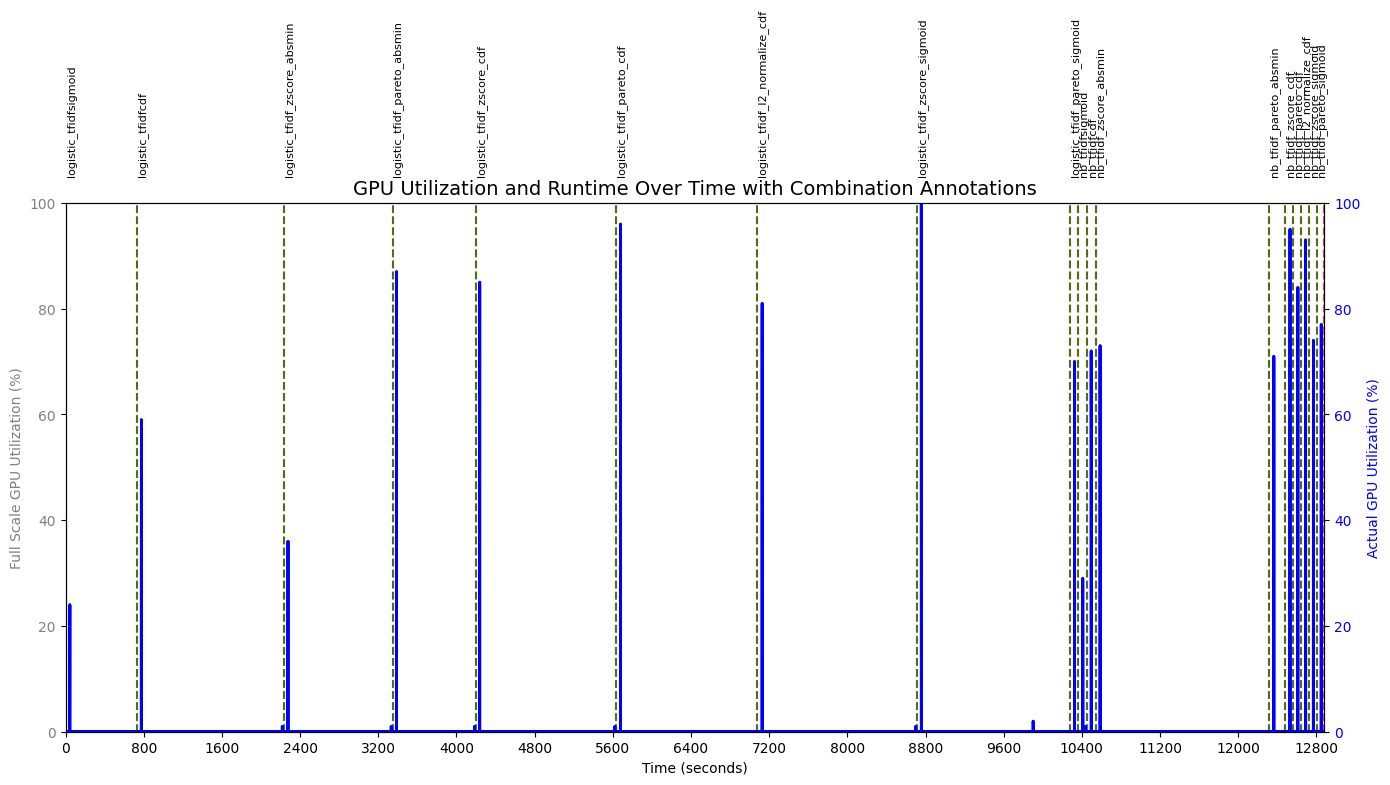


First few rows of GPU DataFrame:
               Start_Time                End_Time  GPU_Utilization  \
0 1900-01-01 14:00:45.080 1900-01-01 14:00:46.210                0   
1 1900-01-01 14:00:46.210 1900-01-01 14:00:47.160                0   
2 1900-01-01 14:00:47.160 1900-01-01 14:00:48.190                0   
3 1900-01-01 14:00:48.190 1900-01-01 14:00:48.770                0   
4 1900-01-01 14:00:48.780 1900-01-01 14:00:49.150                0   

   Cumulative_Start_Seconds  Cumulative_End_Seconds  
0                      0.01                    1.14  
1                      1.14                    2.09  
2                      2.09                    3.12  
3                      3.12                    3.70  
4                      3.71                    4.08  

First few rows of Combination DataFrame:
  Classifier    Feature_Extractor              Start_Time  \
0   logistic         tfidfsigmoid 1900-01-01 14:00:45.070   
1   logistic             tfidfcdf 1900-01-01 14:12:57.040

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log files
gpu_log_path = 'system_metrics.log'
results_log_path = 'results.log'

# Read the log files
with open(gpu_log_path, 'r') as file:
    gpu_log_content = file.read()

with open(results_log_path, 'r') as file:
    results_log_content = file.read()

# Function to parse GPU utilization log
def parse_gpu_log(gpu_log_content):
    gpu_data = []
    lines = gpu_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            line = lines[i].strip()
            if line.startswith('Time start:'):
                start_time = pd.to_datetime(line.split('Time start:')[1].strip(), format='%H:%M:%S,%f')
            elif line.startswith('utilization.gpu [%]'):
                gpu_util = int(lines[i + 1].strip().replace('%', ''))
                end_time = pd.to_datetime(lines[i + 2].strip().split('Time end:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                gpu_data.append((start_time, end_time, gpu_util))
                i += 2  # Skip 'Time end' line
            i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing GPU log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(gpu_data, columns=['Start_Time', 'End_Time', 'GPU_Utilization'])

# Function to parse combinations log
def parse_combination_log(combination_log_content):
    comb_data = []
    lines = combination_log_content.strip().split('\n')
    i = 0
    while i < len(lines):
        try:
            if lines[i].startswith('Running classifier:'):
                classifier = lines[i].split('classifier:')[1].split('with')[0].strip()
                feature_extractor = lines[i].split('feature extractor:')[1].strip()
                start_time = pd.to_datetime(lines[i + 1].split('Start Time:')[1].strip(), format='%H:%M:%S,%f')
                end_time = pd.to_datetime(lines[i + 4].split('End Time:')[1].strip(), format='%H:%M:%S,%f')
                if end_time < start_time:
                    end_time += pd.Timedelta(days=1)
                runtime = (end_time - start_time).total_seconds()
                comb_data.append((classifier, feature_extractor, start_time, end_time, runtime))
                i += 6
            else:
                i += 1
        except (IndexError, ValueError) as e:
            print(f"Error parsing combination log at line {i}: {e}")
            i += 1
            continue
    return pd.DataFrame(comb_data, columns=['Classifier', 'Feature_Extractor', 'Start_Time', 'End_Time', 'Runtime_Seconds'])

# Parse the logs
gpu_df = parse_gpu_log(gpu_log_content)
comb_df = parse_combination_log(results_log_content)

# Filter out irrelevant or erroneous data points (e.g., extremely high values)
gpu_df = gpu_df[gpu_df['GPU_Utilization'] <= 100]

# Convert datetime columns to timestamps
gpu_df['Start_Time'] = pd.to_datetime(gpu_df['Start_Time'])
gpu_df['End_Time'] = pd.to_datetime(gpu_df['End_Time'])
comb_df['Start_Time'] = pd.to_datetime(comb_df['Start_Time'])
comb_df['End_Time'] = pd.to_datetime(comb_df['End_Time'])

# Calculate the runtime for each combination
comb_df['Runtime_Seconds'] = (comb_df['End_Time'] - comb_df['Start_Time']).dt.total_seconds()

# Calculate the cumulative runtime for each combination
comb_df['Cumulative_Start_Seconds'] = comb_df['Runtime_Seconds'].cumsum() - comb_df['Runtime_Seconds']
comb_df['Cumulative_End_Seconds'] = comb_df['Runtime_Seconds'].cumsum()

# Initialize columns for GPU utilization cumulative seconds
gpu_df['Cumulative_Start_Seconds'] = 0.0
gpu_df['Cumulative_End_Seconds'] = 0.0

# Calculate GPU utilization seconds based on cumulative runtime
for i, row in comb_df.iterrows():
    mask = (gpu_df['Start_Time'] >= row['Start_Time']) & (gpu_df['End_Time'] <= row['End_Time'])
    gpu_df.loc[mask, 'Cumulative_Start_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df.loc[mask, 'Start_Time'] - row['Start_Time']).dt.total_seconds()
    gpu_df.loc[mask, 'Cumulative_End_Seconds'] = row['Cumulative_Start_Seconds'] + (gpu_df.loc[mask, 'End_Time'] - row['Start_Time']).dt.total_seconds()

# Display updated DataFrame for verification
print(gpu_df.head())
print(comb_df.head())

# Check for any empty columns
print("Empty columns in gpu_df:")
print(gpu_df.isnull().sum())
print("Empty columns in comb_df:")
print(comb_df.isnull().sum())

print("GPU DataFrame:")
print(gpu_df.describe())
print("\nCombination DataFrame:")
print(comb_df.describe())

# Modify the plotting section:
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot GPU utilization over time as a continuous line
gpu_times = []
gpu_utils = []
for _, row in gpu_df.iterrows():
    gpu_times.extend([row['Cumulative_Start_Seconds'], row['Cumulative_End_Seconds']])
    gpu_utils.extend([row['GPU_Utilization'], row['GPU_Utilization']])

print(f"GPU Times range: {min(gpu_times)} to {max(gpu_times)}")
print(f"GPU Utilizations range: {min(gpu_utils)} to {max(gpu_utils)}")

if len(gpu_times) > 0 and len(gpu_utils) > 0:
    ax1.plot(gpu_times, gpu_utils, color='b', linewidth=2)  # Increased line width
    
    # Create a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(gpu_times, gpu_utils, color='b', linewidth=2)
    
    # Set y-axis limits based on actual data range for ax2
    utilization_min = max(0, min(gpu_utils) - 5)  # Add some padding below
    utilization_max = min(100, max(gpu_utils) + 5)  # Add some padding above
    ax2.set_ylim(utilization_min, utilization_max)
    ax2.set_ylabel('Actual GPU Utilization (%)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
else:
    print("Warning: No GPU utilization data to plot")

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Full Scale GPU Utilization (%)', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.set_ylim(0, 100)  # Keep the full 0-100% scale on the left axis

# Annotate the plot with combinations and runtime
for _, row in comb_df.iterrows():
    ax1.axvline(x=row['Cumulative_Start_Seconds'], color='g', linestyle='--', alpha=0.7)
    ax1.axvline(x=row['Cumulative_End_Seconds'], color='r', linestyle='--', alpha=0.7)
    ax1.text(row['Cumulative_Start_Seconds'], 105, 
             f"{row['Classifier']}_{row['Feature_Extractor']}", 
             rotation=90, verticalalignment='bottom', fontsize=8)

# Set x-axis limits to cover the entire runtime
total_runtime = comb_df['Runtime_Seconds'].sum()
ax1.set_xlim(0, max(total_runtime, 1))  # Ensure the x-axis is at least 1 second wide

# Adding more ticks to the x-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))  # Adjust the number as needed
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.xticks(rotation=45)

# Add title and adjust layout
plt.title('GPU Utilization and Runtime Over Time with Combination Annotations', fontsize=14)
fig.tight_layout()

# Save the plot to a file
fig.savefig("output_graph.png", bbox_inches='tight')

# Display the plot
plt.show()

# Additional debugging: print the first few rows of each DataFrame
print("\nFirst few rows of GPU DataFrame:")
print(gpu_df.head())
print("\nFirst few rows of Combination DataFrame:")
print(comb_df.head())

def calculate_avg_gpu_utilization(gpu_df, comb_row):
    mask = (gpu_df['Cumulative_Start_Seconds'] >= comb_row['Cumulative_Start_Seconds']) & (gpu_df['Cumulative_End_Seconds'] <= comb_row['Cumulative_End_Seconds'])
    avg_utilization = gpu_df.loc[mask, 'GPU_Utilization'].mean()
    return avg_utilization if not pd.isna(avg_utilization) else 0

# Create a new DataFrame for the table
table_data = []
for _, row in comb_df.iterrows():
    avg_gpu_util = calculate_avg_gpu_utilization(gpu_df, row)
    table_data.append({
        'Classifier': row['Classifier'],
        'Feature_Extractor': row['Feature_Extractor'],
        'Runtime_Seconds': row['Runtime_Seconds'],
        'Avg_GPU_Utilization': avg_gpu_util
    })

table_df = pd.DataFrame(table_data)

# Sort the table by runtime (descending order)
table_df = table_df.sort_values('Runtime_Seconds', ascending=False)

# Display the table
print("\nCombinations, Runtime, and Average GPU Utilization:")
print(table_df)

# Save the table to a CSV file
table_df.to_csv('combinations_runtime_gpu_utilization.csv', index=False)
print("\nTable saved to 'combinations_runtime_gpu_utilization.csv'")

# Optionally, you can also save it as an Excel file
table_df.to_excel('combinations_runtime_gpu_utilization.xlsx', index=False)
print("Table saved to 'combinations_runtime_gpu_utilization.xlsx'")

# If you want to display the table in a more formatted way, you can use tabulate
from tabulate import tabulate
print("\nFormatted Table:")
print(tabulate(table_df, headers='keys', tablefmt='pretty'))


In [5]:
import pandas as pd
from io import StringIO

# Your provided data
data = """Classifier,Feature_Extractor,Runtime_Seconds,Avg_GPU_Utilization
nb,tfidf_l2_normalize,48.94,0.0
logistic,tfidf_l2_normalize,48.95,0.0
nb,tfidfn,53.84,0.0
logistic,tfidfn,65.85,0.0
nb,tfidf_l2_normalize_cdf,79.42,1.2567567567567568
nb,tfidf_pareto_sigmoid,79.92,1.3717948717948718
nb,tfidf_pareto_cdf,79.97,1.3417721518987342
nb,tfidf_zscore_sigmoid,80.33,0.9746835443037974
nb,tfidf_zscore_cdf,80.48,1.5375
logistic,tfidf_pareto_sigmoid,85.47,1.1411764705882352
nb,tfidfsigmoid,86.22,0.3529411764705882
nb,tfidfcdf,89.11,0.8181818181818182
nb,tfidf_pareto_absmin,144.04,0.3286713286713286
nb,tfidf_absmin,147.0,0.1917808219178082
nb,tfidf_l2_normalize_minmax,148.2,0.2176870748299319
nb,tfidfminmax,148.48,0.6756756756756757
nb,tfidf_zscore_minmax,148.52,0.6081081081081081
nb,tfidf_pareto_minmax,148.54,0.6054421768707483
nb,tfidf_l2_normalize_absmin,163.82,0.147239263803681
logistic,tfidf_l2_normalize_absmin,234.83,0.1666666666666666
nb,tfidf_l2_normalize_sigmoid,241.46,0.3220338983050847
logistic,tfidf_l2_normalize_minmax,251.01,0.348
logistic,tfidf_zscore_minmax,260.67,0.4015444015444015
logistic,tfidf_pareto_minmax,265.09,0.0232558139534883
logistic,tfidfminmax,273.29,0.4007352941176471
logistic,tfidf_absmin,277.85,0.1227436823104693
logistic,tfidf_l2_normalize_sigmoid,518.46,0.1640926640926641
logistic,tfidfsigmoid,731.96,0.0396210163652024
logistic,tfidf_pareto_absmin,837.28,0.1255980861244019
logistic,tfidf_zscore_absmin,1090.3,0.1220183486238532
logistic,tfidf_pareto_cdf,1271.09,0.1275590551181102
logistic,tfidf_zscore_cdf,1316.16,0.0821292775665399
logistic,tfidf_zscore_sigmoid,1456.74,0.0693681318681318
logistic,tfidfcdf,1500.07,0.0773849232821881
logistic,tfidf_l2_normalize_cdf,1508.75,0.0729442970822281
nb,tfidf_zscore_absmin,1587.74,0.0447385003150598"""

# Read the data into a DataFrame
df = pd.read_csv(StringIO(data))

# Round the Runtime_Seconds to 1 decimal place and Avg_GPU_Utilization to 2 decimal places
df['Runtime_Seconds'] = df['Runtime_Seconds'].round(1)
df['Avg_GPU_Utilization'] = df['Avg_GPU_Utilization'].round(2)

# Sort the DataFrame by Runtime_Seconds
df_sorted = df.sort_values('Runtime_Seconds')

# Display the result
print(df_sorted.to_string(index=False))

# Save the result to a CSV file
df_sorted.to_csv('rounded_gpu_utilization.csv', index=False)
print("\nResults saved to 'rounded_gpu_utilization.csv'")

# Optionally, display the result in a more formatted way using tabulate
try:
    from tabulate import tabulate
    print("\nFormatted Table of Rounded GPU Utilization:")
    print(tabulate(df_sorted, headers='keys', tablefmt='pretty', floatfmt=('.1f', '.2f')))
except ImportError:
    print("\nTo display a formatted table, install tabulate with: pip install tabulate")

Classifier          Feature_Extractor  Runtime_Seconds  Avg_GPU_Utilization
        nb         tfidf_l2_normalize             48.9                 0.00
  logistic         tfidf_l2_normalize             49.0                 0.00
        nb                     tfidfn             53.8                 0.00
  logistic                     tfidfn             65.8                 0.00
        nb     tfidf_l2_normalize_cdf             79.4                 1.26
        nb       tfidf_pareto_sigmoid             79.9                 1.37
        nb           tfidf_pareto_cdf             80.0                 1.34
        nb       tfidf_zscore_sigmoid             80.3                 0.97
        nb           tfidf_zscore_cdf             80.5                 1.54
  logistic       tfidf_pareto_sigmoid             85.5                 1.14
        nb               tfidfsigmoid             86.2                 0.35
        nb                   tfidfcdf             89.1                 0.82
        nb  